## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

features:

    - frequency domain:
        - peaks of ppg (in decreasing power order). e.g. first 10 peaks in interval 40-240BPM
        - peaks of accx
        - peaks of accy
        - peaks of accz
        - peaks of acc total (summed frequencys: accx+accy+accz)
        - peaks of acc total (calculated in time domain and then fft)
        - fraction of spectral energy in each 1Hz from 1 to 4 Hz of ppg signal
        - fraction of spectral energy in each 1Hz from 1 to 4 Hz of total acc signal
        
    - time domain:
        - mean of ppg signal (evtl. acc signals)
        - std of ppg signal (evtl. acc signals)
        - evtl. correlations between accx and ppg signal
        - evtl. correlations between accy and ppg signal
        - evtl. correlations between accz and ppg signal
        - evtl. correlations between acc and ppg signal


### Code

In [1]:
import glob
import sys
import numpy as np
import scipy as sp
import pandas as pd
import itertools
import scipy.signal
import scipy.io
import sklearn
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestRegressor
import etl
import plot_util
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Scipy version: {sp.__version__}')
print(f'sklearn version: {sklearn.__version__}')

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
Numpy version: 1.19.1
Scipy version: 1.5.2
sklearn version: 0.23.2


In [218]:
def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates in BPM.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = etl.LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


# def RunPulseRateAlgorithm(data_fl, ref_fl):
#     """
#     Infer the pulse rate of a time signal and compare it with the labels ref_fl
#     Return per-estimate errors and confidence as a 2-tuple of numpy arrays.
#     :param data_fl:
#     :param ref_fl:
#     :return:
#     """
#     # hyperparameters:
#     # sampling frequency:
#     FS = 125
#     # window sizes in seconds:
#     WINDOW_LENGTH_SEC = 8
#     WINDOW_SHIFT_SEC = 2
#     # transform to data points:
#     window_length = WINDOW_LENGTH_SEC * FS
#     window_shift = WINDOW_SHIFT_SEC * FS
#     BPM_MIN = 40
#     BPM_MAX = 240
#     # transform to Hz:
#     min_freq = BPM_MIN / 60
#     max_freq = BPM_MAX / 60
#     # fft window length
#     # use n>len(time_series) -> we pad the input signal with
#     # zeros so that we get a higher resolution in frequency space
#     n_fft = window_length * 4
#     peaks_param = {
#         'ppg': {
#             'nr_peaks': 4,
#             'height': 0.2,
#             'distance': 10,
#             'prominence': None,
#             'wlen': None,
#             'pad_value': -1,
#         },
#         'acc_abs': {
#             'nr_peaks': 4,
#             'height': 0.2,
#             'distance': 10,
#             'prominence': None,
#             'wlen': None,
#             'pad_value': -1,
#         },
#     }

#     frac_en_param = {
#         'ppg': {
#             'num_intervals': 4,
#         },
#         'acc_abs': {
#             'num_intervals': 4,
#         },
#     }

#     # Load data and labels:
#     ppg, accx, accy, accz = etl.LoadTroikaDataFile(data_fl=data_fl)
#     labels_raw = list(etl.import_labels(files=[ref_fl]).values())[0]
    
#     # 
#     infer_data, infer_features, infere_data_names = etl.prepare_inference_data(
#         ppg=ppg,
#         accx=accx,
#         accy=accy,
#         accz=accz,
#         window_length=window_length,
#         window_shift=window_shift,
#         freq_range=(min_freq, max_freq),
#         fs=FS,
#         n_fft=n_fft,
#         peaks_param=peaks_param,
#         frac_en_param=frac_en_param
#     )
#     # predict pulse rate estimates (in bpm):
#     infer_pred = best_model.predict(infer_features)

#     # per-estimate error:
#     errors = infer_pred - labels_raw
    
#     # confidence of each estimate:
#     # we sum the frequency spectrum near the pulse rate estimate and dividing
#     # it by the sum of the entire spectrum (defined by the min_freq and max_freq interval)..
#     confidence_freq_range = 0.1 * (max_freq - min_freq)
#     cfd = confidence(
#         freqs=infer_data['freqs'],
#         fft=infer_data['fft_ppg'],
#         y_pred=infer_pred,
#         confidence_freq_range=confidence_freq_range,
#         freq_range=(min_freq, max_freq)
#     )

#     return errors, cfd

In [3]:
def hyperparam_selection(features, labels, groups, n_estimators_opt, max_tree_depth_opt):
    """
    Train a random Forest Regression Algorithm to get the best hyperparameters 
    (n_estimators, max_tree_depth) and an idea of the performance of the parameter
    on the given dataset (defined by arguments features, labels, groups).
    In detail, we perform a nested cross validation:
    To get an accurate idea of the performance of the ML model (Random Forest Regressor),
    we pick the best hyperparameters (based on a validation set) on a subset of the data
    and evaluate it on a hold-out-set (test set). This is similar to 
    train-validation-test set split. Since the dataset is too small to separate
    it into 3 parts, we nest the hyperparameter selection in another
    layer of cross validation.
    :param features: all features the Random Forest Regressor uses for training
    :param labels: labels for each data point in features np.array
    :param groups: group each data point in features np.array belongs to
    :param n_estimators_opt: list of Random Forest hyperparameters n_estimator to use
        for training. The best n_estimator value for each test set will be safed in 
        the output DataFrame.
    :param max_tree_depth_opt: list of Random Forest hyperparameters max_tree_depth to
        use for training. The best max_tree_depth value for each test set will be safed
        in the output DataFrame.
    :return: pandas DataFrame with list of parameters and validation and test set metrics
    """
    # initialize cross validation:
    # 1 group is left out for validation or testing, the rest is used for training
    logo = LeaveOneGroupOut()
    # counter for printing iterations:
    splits = 0
    df_best_hparams = pd.DataFrame()
    # iterate over each cross-validation fold (in the first
    # iteration the indices of the first group are assigned to test_ind,
    # and the remaining indices are asigned to train_valid_ind, in the second
    # iteration the indices of the second group are assigned to test_ind,
    # and so on):
    nr_data_splits = len(list(logo.split(X=features, y=labels, groups=groups)))
    for train_valid_ind, test_ind in logo.split(X=features, y=labels, groups=groups):
        # split the dataset into a combined training and validation dataset and a
        # test set in this cross-validation fold (the training set has data from
        # only 1 group):
        # training and validation dataset:
        X_train_valid, y_train_valid = features[train_valid_ind], labels[train_valid_ind]
        # testing dataset:
        X_test, y_test = features[test_ind], labels[test_ind]
        # compute new groups array for next (nested) cross validation
        # (training / validation split):
        groups_train_valid = groups[train_valid_ind]


        ## Model selection on validation set:
        # storage for all evaluation metrics of all hyperparameter sets:
        valid_eval_metrics = []

        hparams_cross_product = itertools.product(n_estimators_opt, max_tree_depth_opt)
        for n_estimators, max_tree_depth in hparams_cross_product:
            # define regressor (ml model) for each set of hyperparameters:
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_tree_depth,
                random_state=42,
                n_jobs=8
            )
            # initialize lists to collect information for evaluation metrics
            valid_score = []
            abs_valid_error = []
            # iterate over each cross-validation fold (in the first
            # iteration the indices of the first group are assigned to valid_ind,
            # and the remaining indices are asigned to train_ind, in the second
            # iteration the indices of the second group are assigned to valid_ind,
            # and so on):
            for train_ind, valid_ind in logo.split(X=X_train_valid, y=y_train_valid, groups=groups_train_valid):
                # split the dataset into training and validation dataset in 
                # this cross-validation fold (the validation set has data from
                # only 1 group):
                X_train, y_train = features[train_ind], labels[train_ind]
                X_valid, y_valid = features[valid_ind], labels[valid_ind]

                # train machine learning model
                # by calling the fit method, the model gets fitted to the current train data
                # if the model has been trained before (on a different train data) its saved
                # state (weights/decision paths/etc.) is overwritten:
                model.fit(X_train, y_train)

                # run ml model on the current validation set:
                y_pred_valid = model.predict(X_valid)

                # compute (rolling) scores for model evaluation
                valid_score += [model.score(X=X_valid, y=y_valid)]
                # compute (rolling) basis for calculating MSE and MAE for validation dataset:
                abs_valid_error += [np.abs(y_valid - y_pred_valid)]

            # transform validation scores to numpy array:
            valid_score = np.array(valid_score)
            # compute MAE and MSE for all validation sets with this hyperparameter sets
            # we compute all validation set based metrics over all validation sets (mean, std)
            # so that we get a metric that tells us what hyperparameters work best on the 
            # total dataset that is used for training and validation:
            abs_valid_error = np.concatenate(abs_valid_error)
            mae_valid = np.mean(abs_valid_error)
            mse_valid = np.mean(np.square(abs_valid_error))

            # wirte all evaluation metrics (for each hyperparameter set) to a summary list:
            valid_eval_metrics += [(
                n_estimators, max_tree_depth, mse_valid,
                mae_valid, valid_score.mean(),
                valid_score.std()
            )]

        # transform evaluation metric table to pd dataframe:
        df_valid_eval_metrics = pd.DataFrame(
            valid_eval_metrics,
            columns=['n_estimators', 'max_tree_depth', 'valid_mse',
                     'valid_mae', 'valid_score_mean', 'valid_score_std'])

        # create model with best pair of hyperparameters for this training and validation set:
        ser_best_hparams = df_valid_eval_metrics.loc[df_valid_eval_metrics['valid_mae'].argmin()].copy(deep=True)
        # train a new model on the test set with the best hyperparameter estimates
        best_model = RandomForestRegressor(
            n_estimators=int(ser_best_hparams['n_estimators']),
            max_depth=int(ser_best_hparams['max_tree_depth']),
            random_state=42,
            n_jobs=8
        )
        # fit model to the complete training + validation set
        best_model.fit(X_train_valid, y_train_valid)
        y_pred_test = best_model.predict(X_test)
        mse_test = sklearn.metrics.mean_squared_error(y_true=y_test, y_pred=y_pred_test)
        mae_test = sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
        ser_best_hparams['test_mse'] = mse_test
        ser_best_hparams['test_mae'] = mae_test
        df_best_hparams = df_best_hparams.append(ser_best_hparams)

        splits += 1
        print(f'it. {splits}/{nr_data_splits}: MAE test set: {mae_test}')

    # reset index of dataframe:
    df_best_hparams = df_best_hparams.reset_index(drop=True)
    return df_best_hparams

In [4]:
# not used right now:
# maybe add means and stds to 
# # mean of time signal:
# np.mean(dict_data_raw_window['ppg'], axis=1)
# # std of time signal:
# np.std(dict_data_raw_window['ppg'], axis=1)

# # calculate mean of fft signal in relevant frequency range in vectorized form:
# msk = (dict_data_raw_window['freqs']>=min_freq) & (dict_data_raw_window['freqs']<=max_freq)
# mean = (dict_data_raw_window['fft_ppg'] * msk).sum(axis=1) / msk.sum(axis=1)
# # calculate std of fft signal in relevant frequency range in vectorized form:
# mean_matrix = msk * np.broadcast_to(mean, msk.transpose().shape).transpose()
# std = np.sqrt((((dict_data_raw_window['fft_ppg'] * msk) - mean_matrix)**2).sum(axis=1)/msk.sum(axis=1))


In [389]:
# hyperparameters:
# sampling frequency:
FS = 125
# window sizes in seconds:
WINDOW_LENGTH_SEC = 8
WINDOW_SHIFT_SEC = 2
# transform to data points:
window_length = WINDOW_LENGTH_SEC * FS
window_shift = WINDOW_SHIFT_SEC * FS
BPM_MIN = 40
BPM_MAX = 240
# transform to Hz:
min_freq = BPM_MIN / 60
max_freq = BPM_MAX / 60
# fft window length
# use n>len(time_series) -> we pad the input signal with
# zeros so that we get a higher resolution in frequency space
n_fft = window_length * 4

# number of trees in Random forest:
# n_estimators_opt = [2, 10, 20, 50, 100, 150, 300]
# max_tree_depth_opt = range(2, 7)
n_estimators_opt = [100, 130, 150, 160, 170, 200]
max_tree_depth_opt = [10, 11, 12, 14, 15, 16, 18, 20]

# peaks_param = {
#     'ppg': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': None,
#         'wlen': None,
#         'pad_value': -1,
#     },
# #     'accx': {
# #         'nr_peaks': 4,
# #         'height': 0.2,
# #         'distance': 10,
# #         'prominence': None,
# #         'wlen': None,
# #         'pad_value': -1,
# #     },
# #     'accy': {
# #         'nr_peaks': 4,
# #         'height': 0.2,
# #         'distance': 10,
# #         'prominence': None,
# #         'wlen': None,
# #         'pad_value': -1,
# #     },
# #     'accz': {
# #         'nr_peaks': 4,
# #         'height': 0.2,
# #         'distance': 10,
# #         'prominence': None,
# #         'wlen': None,
# #         'pad_value': -1,
# #     },
#     'acc_abs': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': None,
#         'wlen': None,
#         'pad_value': -1,
#     },
#     'acc_sum': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': None,
#         'wlen': None,
#         'pad_value': -1,
#     },
# }
# peaks_param = {
#     'ppg': {
#         'nr_peaks': 5,
#         'height': 0.3,
#         'distance': 5,
#         'prominence': 0.2,
#         'wlen': None,
#         'pad_value': -1,
#     },
#     'acc_abs': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': None,
#         'wlen': None,
#         'pad_value': -1,
#     },
#     'acc_sum': {
#         'nr_peaks': 8,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': None,
#         'wlen': None,
#         'pad_value': -1,
#     },
# }
peaks_param = {
    'ppg': {
        'nr_peaks': 3,
        'height': 0.1,
        'distance': 5,
        'prominence': 0.2,
        'wlen': 200,
        'pad_value': -1,
    },
#     'acc_abs': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': 0.2,
#         'wlen': 100,
#         'pad_value': -1,
#     },
    'acc_sum': {
        'nr_peaks': 3,
        'height': 0.2,
        'distance': 10,
        'prominence': 0.2,
        'wlen': 100,
        'pad_value': -1,
    },
}
frac_en_param = {
#     'ppg': {
#         'num_intervals': 8,
#     },
# #     'acc_abs': {
# #         'num_intervals': 4,
# #     },
#     'acc_sum': {
#         'num_intervals': 8,
#     },
}

In [390]:
%%time
# read data files:
data_files, ref_files = etl.LoadTroikaDataset()
# # print information about imported files
# etl.data_information(
#     file_data=data_files,
#     file_label=ref_files,
#     fs=FS,
#     window_shift_sec=WINDOW_SHIFT_SEC,
#     window_length_sec=WINDOW_LENGTH_SEC
# )
# import raw input data:
input_data_raw = etl.import_input_data(files=data_files)
# import labels:
labels_raw = etl.import_labels(files=ref_files)

# get raw (window) data:
dict_data_raw_window, labels, groups = etl.raw_data(
    input_data_raw=input_data_raw,
    labels_raw=labels_raw,
    window_length=window_length,
    window_shift=window_shift,
    freq_range=(min_freq, max_freq),
    fs=FS,
    n_fft=n_fft)
# get labels in Hz:
labels = labels

CPU times: user 556 ms, sys: 52.3 ms, total: 608 ms
Wall time: 609 ms


In [391]:
%%time
# get all features:
dict_features = etl.featurize(
    dict_raw_window_data=dict_data_raw_window,
    peaks_param=peaks_param,
    frac_en_param=frac_en_param,
    freq_range=(min_freq, max_freq)
)
features, feature_names = etl.transform_features(dict_features=dict_features)

CPU times: user 475 ms, sys: 0 ns, total: 475 ms
Wall time: 475 ms


In [392]:
%%time
df_best_hparams = hyperparam_selection(
    features=features,
    labels=labels,
    groups=groups,
    n_estimators_opt=n_estimators_opt,
    max_tree_depth_opt=max_tree_depth_opt
)

it. 1/12: MAE test set: 15.246100992998162
it. 2/12: MAE test set: 13.13110558237426
it. 3/12: MAE test set: 11.794192067071922
it. 4/12: MAE test set: 9.286507833814305
it. 5/12: MAE test set: 16.099846669529725
it. 6/12: MAE test set: 10.821038150283643
it. 7/12: MAE test set: 10.600645484421772
it. 8/12: MAE test set: 9.878552372938392
it. 9/12: MAE test set: 6.752504029836793
it. 10/12: MAE test set: 21.607873670916295
it. 11/12: MAE test set: 9.706187512558275
it. 12/12: MAE test set: 10.88772124940467
CPU times: user 2h 28s, sys: 2min 44s, total: 2h 3min 12s
Wall time: 29min 19s


In [393]:
df_best_hparams

,max_tree_depth,n_estimators,test_mae,test_mse,valid_mae,valid_mse,valid_score_mean,valid_score_std
0,18.0,130.0,15.246101,456.716458,12.462300,272.657051,0.333198,0.585758
1,18.0,130.0,13.131106,307.692694,12.462300,272.657051,0.333198,0.585758
2,15.0,150.0,11.794192,214.560848,12.403114,272.802667,0.271317,0.623427
3,12.0,150.0,9.286508,141.444958,12.588769,278.824806,0.243179,0.483684
4,16.0,130.0,16.099847,429.428127,12.393608,273.438671,0.182479,0.649260
5,16.0,130.0,10.821038,182.541704,12.393608,273.438671,0.182479,0.649260
6,16.0,130.0,10.600645,249.014038,12.652829,282.264862,0.198715,0.574200
7,15.0,170.0,9.878552,147.456129,12.523586,275.186679,0.134539,0.730017
8,18.0,100.0,6.752504,83.607448,13.060255,302.561024,0.218568,0.462016
9,16.0,130.0,21.607874,556.895482,12.531006,277.479232,0.200119,0.625898


In [394]:
def train_rpr_algorithm(df_hparams, features, labels):
    """
    
    """
    best_max_tree_depth = df_hparams['max_tree_depth'].value_counts().sort_values(ascending=False)
    best_max_tree_depth = int(best_max_tree_depth.index[0])

    best_n_estimators = df_hparams['n_estimators'].value_counts().sort_values(ascending=False)
    best_n_estimators = int(best_n_estimators.index[0])

    model = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_tree_depth,
        random_state=42,
        n_jobs=8
    )
    model.fit(features, labels)
    return model

In [395]:
model = train_rpr_algorithm(df_hparams=df_best_hparams, features=features, labels=labels)
model

RandomForestRegressor(max_depth=16, n_estimators=130, n_jobs=8, random_state=42)

In [ ]:
RandomForestRegressor(max_depth=16, n_estimators=130, n_jobs=8, random_state=42) -> 8.887

In [396]:
sorted(list(zip(model.feature_importances_, feature_names)), reverse=True)

[(0.28925802124035366, 'peaks_pwr_acc_sum_1'),
 (0.2638042667611911, 'peaks_pwr_ppg_0'),
 (0.1958992528523166, 'peaks_freq_ppg_0'),
 (0.06277271653903746, 'peaks_freq_acc_sum_0'),
 (0.0550963856259426, 'peaks_pwr_acc_sum_0'),
 (0.03562612121325808, 'peaks_freq_ppg_1'),
 (0.028912532662135688, 'peaks_freq_ppg_2'),
 (0.02830525440891825, 'peaks_pwr_ppg_1'),
 (0.013676712734262507, 'peaks_freq_acc_sum_1'),
 (0.013154108893319465, 'peaks_pwr_ppg_2'),
 (0.007110750328979258, 'peaks_pwr_acc_sum_2'),
 (0.006383876740285329, 'peaks_freq_acc_sum_2')]

# inference

In [397]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Infer the pulse rate of a time signal and compare it with the labels ref_fl
    Return per-estimate errors and confidence as a 2-tuple of numpy arrays.
    """
    # hyperparameters:
    # sampling frequency:
    FS = 125
    # window sizes in seconds:
    WINDOW_LENGTH_SEC = 8
    WINDOW_SHIFT_SEC = 2
    # transform to data points:
    window_length = WINDOW_LENGTH_SEC * FS
    window_shift = WINDOW_SHIFT_SEC * FS
    BPM_MIN = 40
    BPM_MAX = 240
    # transform to Hz:
    min_freq = BPM_MIN / 60
    max_freq = BPM_MAX / 60
    # fft window length
    # use n>len(time_series) -> we pad the input signal with
    # zeros so that we get a higher resolution in frequency space
    n_fft = window_length * 4
    peaks_param = {
        'ppg': {
            'nr_peaks': 3,
            'height': 0.1,
            'distance': 5,
            'prominence': 0.2,
            'wlen': 200,
            'pad_value': -1,
        },
    #     'acc_abs': {
    #         'nr_peaks': 4,
    #         'height': 0.2,
    #         'distance': 10,
    #         'prominence': 0.2,
    #         'wlen': 100,
    #         'pad_value': -1,
    #     },
        'acc_sum': {
            'nr_peaks': 3,
            'height': 0.2,
            'distance': 10,
            'prominence': 0.2,
            'wlen': 100,
            'pad_value': -1,
        },
    }
    frac_en_param = {}    
    
    # Load data and labels:
    ppg, accx, accy, accz = etl.LoadTroikaDataFile(data_fl=data_fl)
    labels_raw = list(etl.import_labels(files=[ref_fl]).values())[0]
    
    # 
    infer_data, infer_features, infere_data_names = etl.prepare_inference_data(
        ppg=ppg,
        accx=accx,
        accy=accy,
        accz=accz,
        window_length=window_length,
        window_shift=window_shift,
        freq_range=(min_freq, max_freq),
        fs=FS,
        n_fft=n_fft,
        peaks_param=peaks_param,
        frac_en_param=frac_en_param
    )
    # predict pulse rate estimates (in bpm):
    infer_pred = model.predict(infer_features)

    # per-estimate error:
    errors = infer_pred - labels_raw
    
    # confidence of each estimate:
    # we sum the frequency spectrum near the pulse rate estimate and dividing
    # it by the sum of the entire spectrum (defined by the min_freq and max_freq interval)..
    confidence_freq_range = 0.1 * (max_freq - min_freq)
    cfd = etl.confidence(
        freqs=infer_data['freqs'],
        fft=infer_data['fft_ppg'],
        y_pred=infer_pred,
        confidence_freq_range=confidence_freq_range,
        freq_range=(min_freq, max_freq)
    )

    return errors, cfd


In [402]:
errors, cfd = RunPulseRateAlgorithm(
    data_fl=data_files[0],
    ref_fl=ref_files[0]
)
AggregateErrorMetric(pr_errors=errors, confidence_est=cfd)

2.755421304323262

In [405]:
np.abs(errors)

22.78899780315416

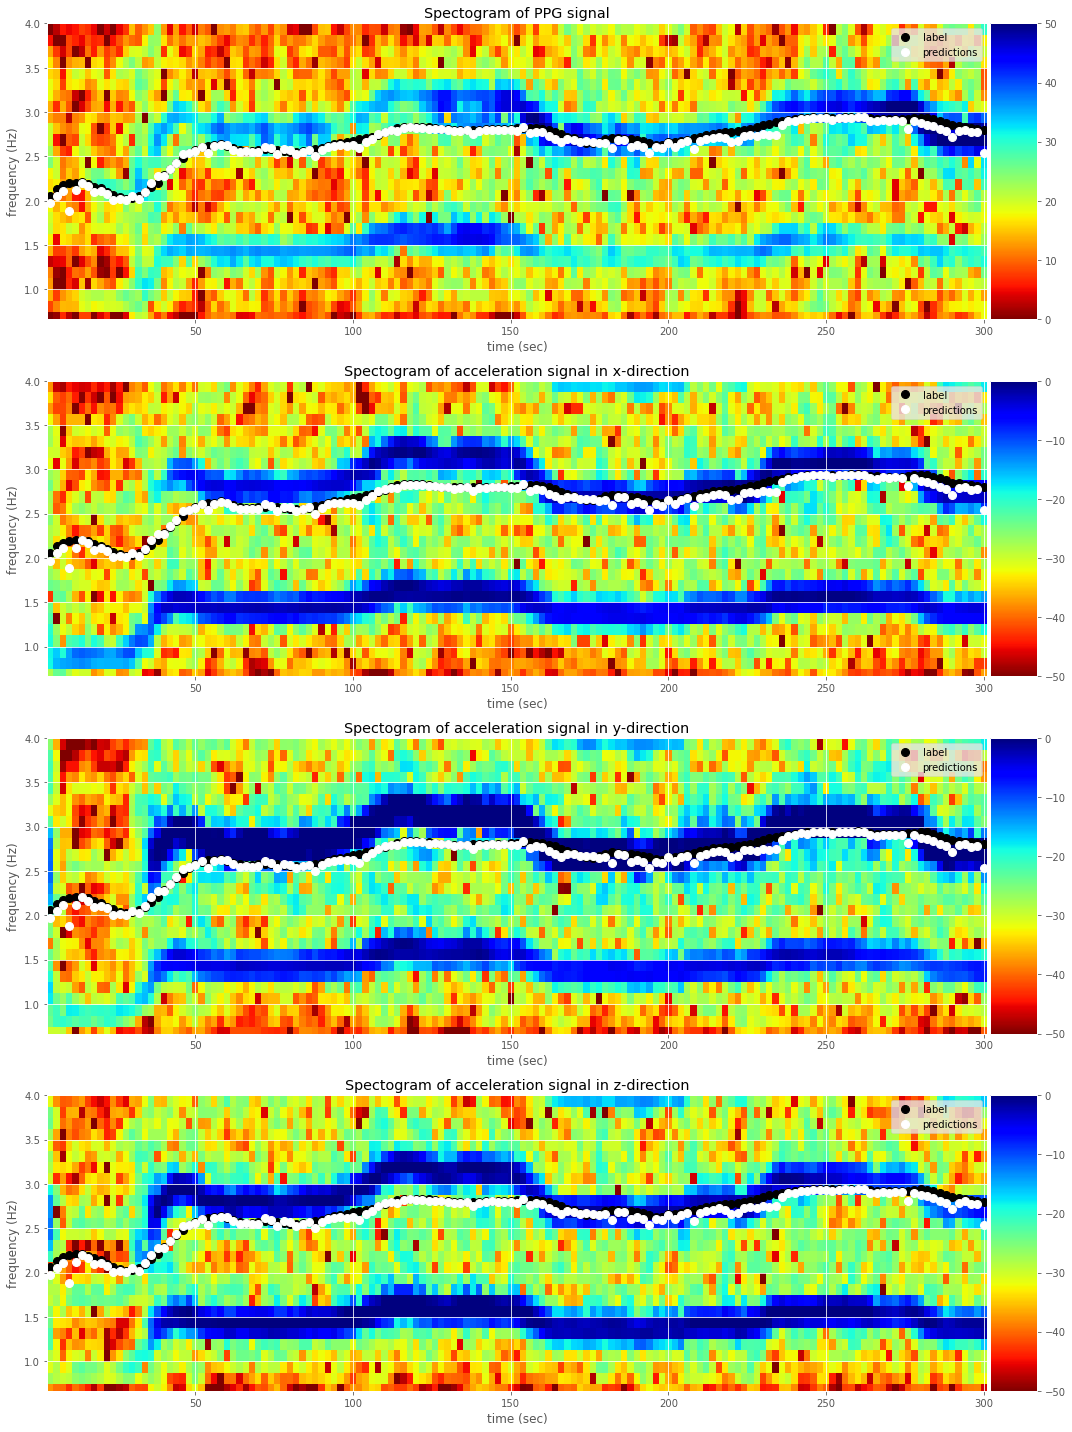

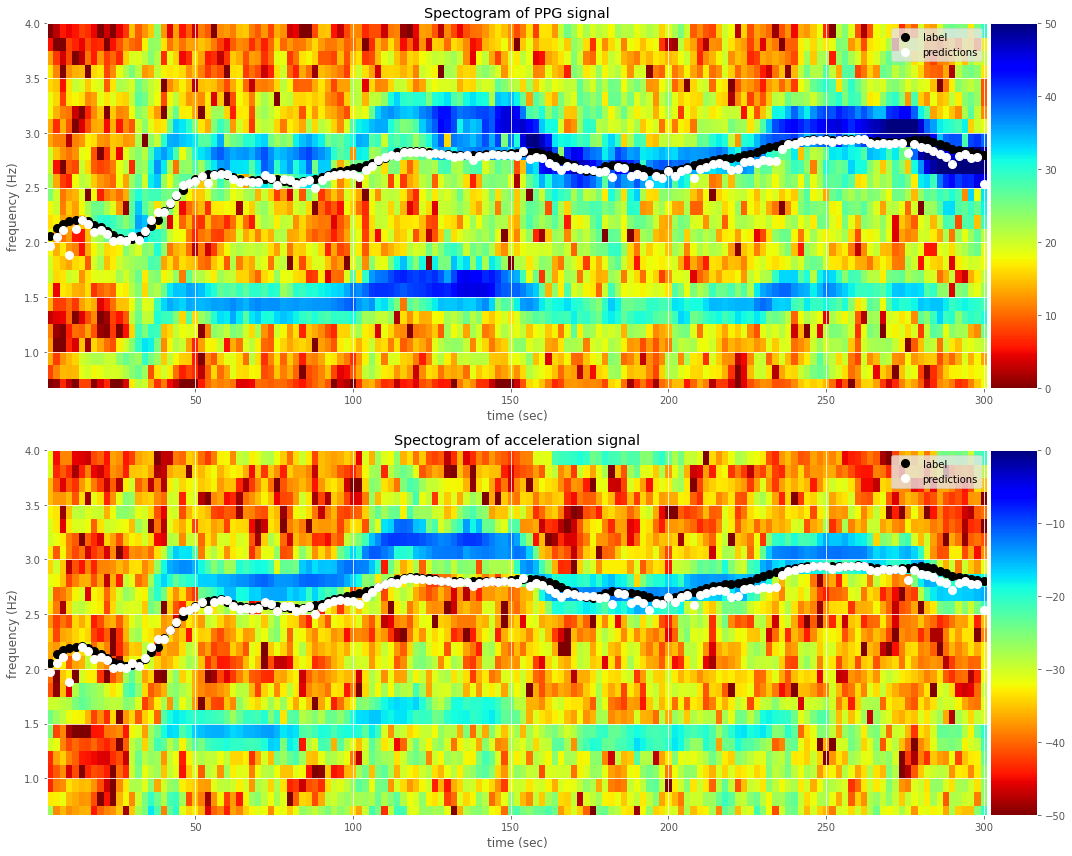

In [399]:
file = data_files[9]

ppg, accx, accy, accz = etl.LoadTroikaDataFile(data_fl=file)
file_key = file.split('/')[-1].split('.')[0].lower()
ppg_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['ppg'], pass_band=(min_freq, max_freq), fs=FS)
accx_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['accx'], pass_band=(min_freq, max_freq), fs=FS)
accy_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['accy'], pass_band=(min_freq, max_freq), fs=FS)
accz_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['accz'], pass_band=(min_freq, max_freq), fs=FS)
acc_abs, _ = etl.total_accelerometer_signal(accx=accx_raw_filtered, accy=accy_raw_filtered, accz=accz_raw_filtered, n_fft=n_fft)
lbls = labels_raw[f'ref{file_key[4:]}']/60

infer_data, infer_features, infere_data_names = etl.prepare_inference_data(
    ppg=ppg,
    accx=accx,
    accy=accy,
    accz=accz,
    window_length=window_length,
    window_shift=window_shift,
    freq_range=(min_freq, max_freq),
    fs=FS,
    n_fft=n_fft,
    peaks_param=peaks_param,
    frac_en_param=frac_en_param
)
# predict pulse rate estimates (in bpm):
pred = model.predict(infer_features)

fig = plot_util.plot_spectogram(
    ppg=ppg_raw_filtered,
    accx=accx_raw_filtered,
    accy=accy_raw_filtered,
    accz=accz_raw_filtered,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

fig = plot_util.plot_spectogram_sumarized(
    ppg=ppg_raw_filtered,
    acc=acc_abs,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

# Real test set evaluations

In [400]:
def load_test_data():
    """
    Get filenames in considered data directory.
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data (labels)
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/test_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def Evaluate_test_data():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = load_test_data()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)



data_files_test, ref_files_test = load_test_data()
ppg, accx, accy, accz = etl.LoadTroikaDataFile(data_fl=data_files_test[0])
# labels_raw_test = etl.import_labels(files=ref_files_test)

errors, cfd = RunPulseRateAlgorithm(data_fl=data_files_test[0], ref_fl=ref_files_test[0])
AggregateErrorMetric(pr_errors=errors, confidence_est=cfd)

8.88767154179407

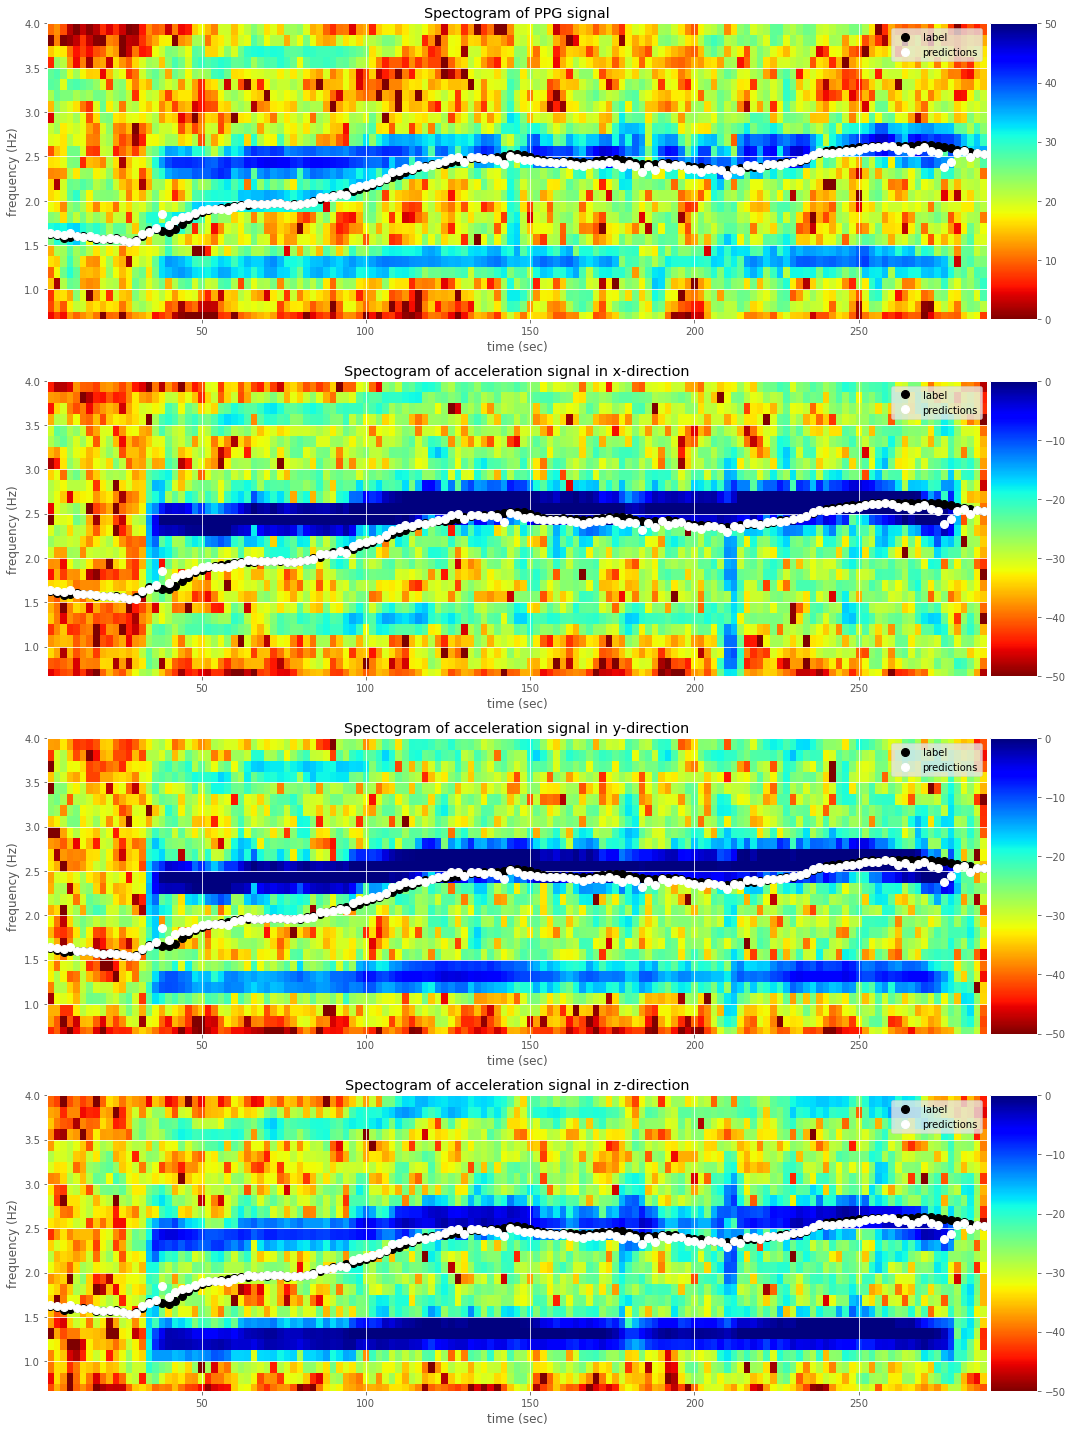

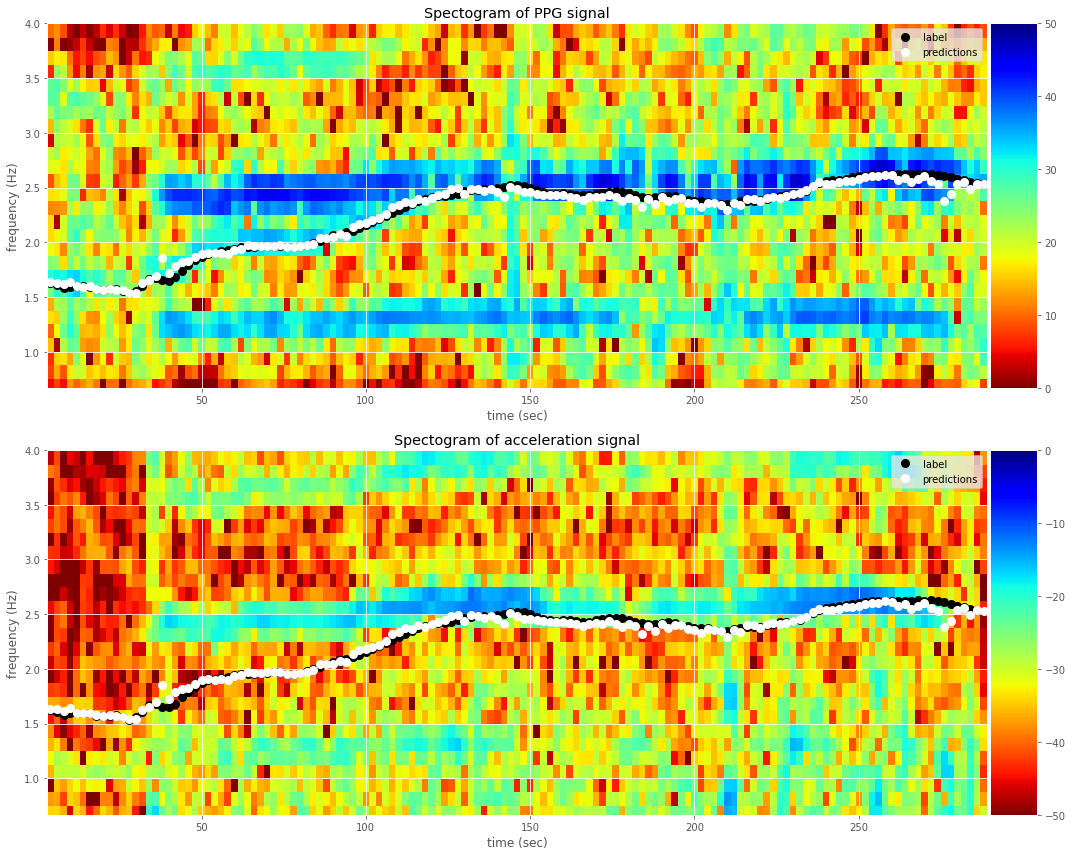

In [374]:
file = data_files[7]

ppg, accx, accy, accz = etl.LoadTroikaDataFile(data_fl=file)
file_key = file.split('/')[-1].split('.')[0].lower()
ppg_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['ppg'], pass_band=(min_freq, max_freq), fs=FS)
accx_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['accx'], pass_band=(min_freq, max_freq), fs=FS)
accy_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['accy'], pass_band=(min_freq, max_freq), fs=FS)
accz_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file_key]['accz'], pass_band=(min_freq, max_freq), fs=FS)
acc_abs, _ = etl.total_accelerometer_signal(accx=accx_raw_filtered, accy=accy_raw_filtered, accz=accz_raw_filtered, n_fft=n_fft)
lbls = labels_raw[f'ref{file_key[4:]}']/60

infer_data, infer_features, infere_data_names = etl.prepare_inference_data(
    ppg=ppg,
    accx=accx,
    accy=accy,
    accz=accz,
    window_length=window_length,
    window_shift=window_shift,
    freq_range=(min_freq, max_freq),
    fs=FS,
    n_fft=n_fft,
    peaks_param=peaks_param,
    frac_en_param=frac_en_param
)
# predict pulse rate estimates (in bpm):
pred = model.predict(infer_features)

fig = plot_util.plot_spectogram(
    ppg=ppg_raw_filtered,
    accx=accx_raw_filtered,
    accy=accy_raw_filtered,
    accz=accz_raw_filtered,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

fig = plot_util.plot_spectogram_sumarized(
    ppg=ppg_raw_filtered,
    acc=acc_abs,
    labels=lbls,
    predictions=pred/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

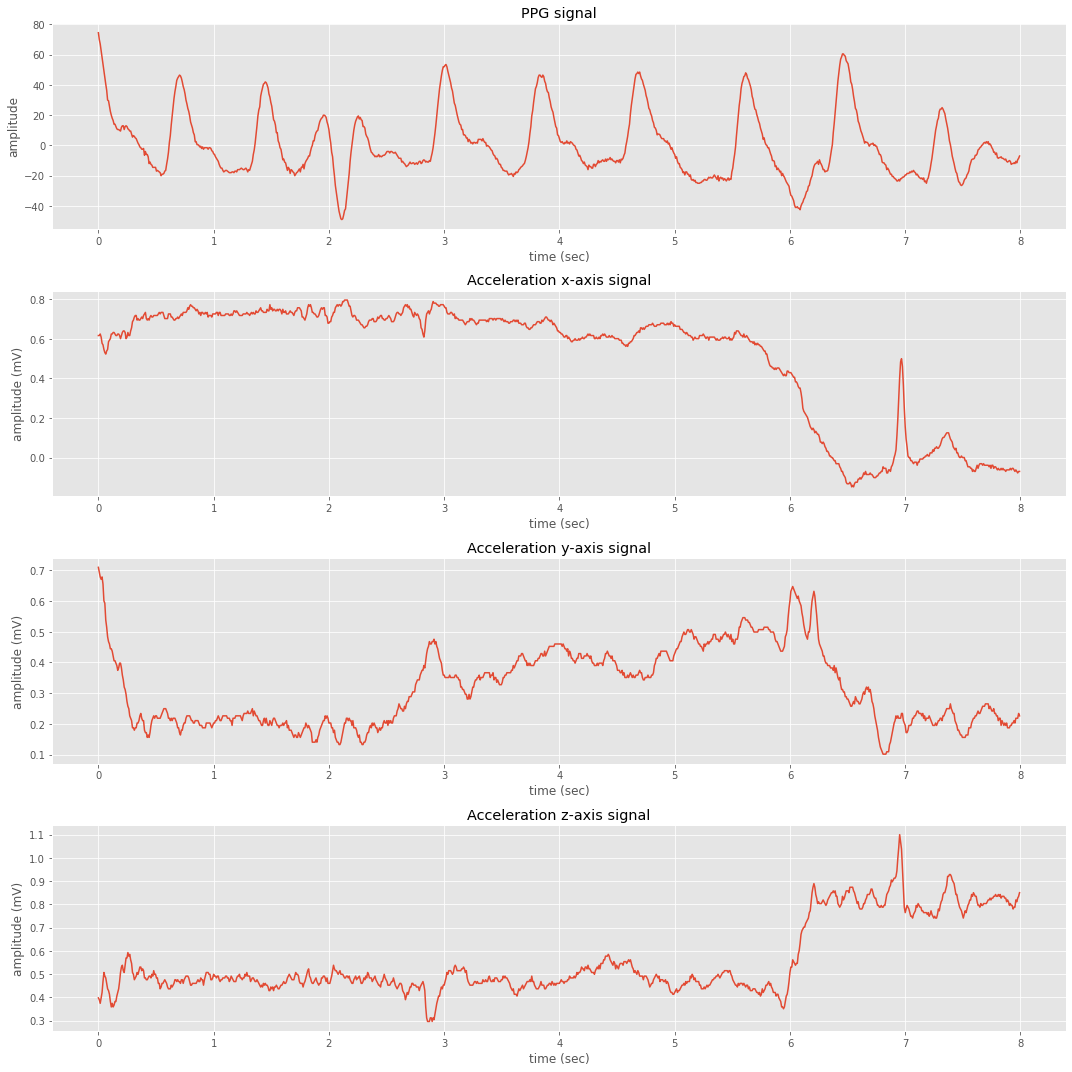

In [26]:
i=4
# plot (raw) time signals:
fig = plot_util.plot_raw_signals(
    ppg=dict_data_raw_window['ppg'][i],
    accx=dict_data_raw_window['accx'][i],
    accy=dict_data_raw_window['accy'][i],
    accz=dict_data_raw_window['accz'][i],
    fs=FS
)

In [27]:
dict_data_raw_window.keys()

dict_keys(['ppg', 'accx', 'accy', 'accz', 'ppg_filtered', 'freqs', 'fft_ppg', 'accx_filtered', 'fft_accx', 'accy_filtered', 'fft_accy', 'accz_filtered', 'fft_accz', 'acc_abs_filtered', 'fft_acc_abs', 'fft_acc_sum'])

In [28]:
peaks_param

{'ppg': {'nr_peaks': 4,
  'height': 0.2,
  'distance': 10,
  'prominence': None,
  'wlen': None,
  'pad_value': -1},
 'acc_abs': {'nr_peaks': 4,
  'height': 0.2,
  'distance': 10,
  'prominence': None,
  'wlen': None,
  'pad_value': -1}}

In [29]:
dict_data_raw_window['freqs'].shape

(1726, 2001)

In [30]:
dict_features.keys()#['peaks_freq_acc_sum']

dict_keys(['peaks_freq_ppg', 'peaks_pwr_ppg', 'frac_en_int0_ppg', 'frac_en_int1_ppg', 'frac_en_int2_ppg', 'peaks_freq_acc_abs', 'peaks_pwr_acc_abs', 'frac_en_int0_acc_abs', 'frac_en_int1_acc_abs', 'frac_en_int2_acc_abs'])

group: data_01_type01
label: 151.59574468085106 BPM (2.526595744680851 Hz)


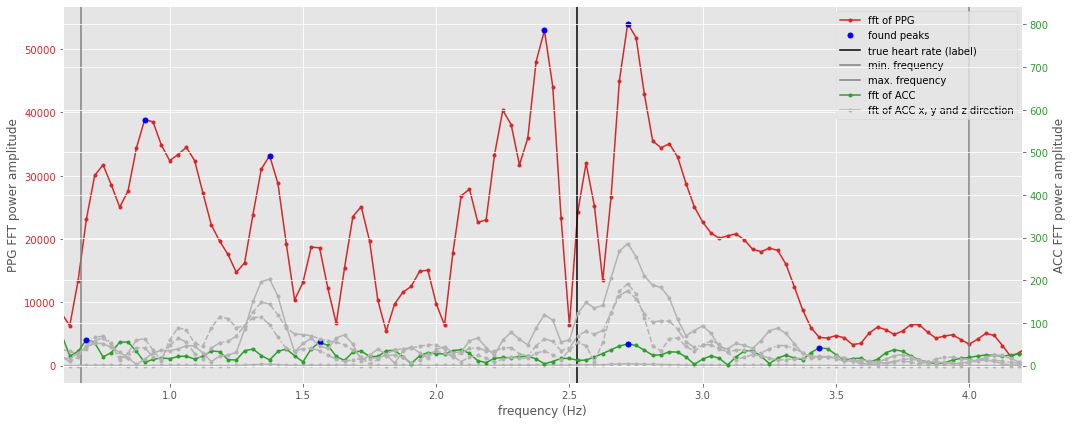

In [31]:
# plot a window data point
i = 100
fig = plot_util.plot_window_prediction(
    freqs=dict_data_raw_window['freqs'][i],
    ppg_fft=dict_data_raw_window['fft_ppg'][i],
    ppg_peaks_freqs=dict_features['peaks_freq_ppg'][i],
    ppg_peaks_pwr=dict_features['peaks_pwr_ppg'][i],
    ppg_label=labels[i],
    acc_fft=dict_data_raw_window['fft_acc_abs'][i],
    accx_fft=dict_data_raw_window['fft_accx'][i],
    accy_fft=dict_data_raw_window['fft_accy'][i],
    accz_fft=dict_data_raw_window['fft_accz'][i],
    acc_peaks_freqs=dict_features['peaks_freq_acc_abs'][i],
    acc_peaks_pwr=dict_features['peaks_pwr_acc_abs'][i],
    min_freq=min_freq,
    max_freq=max_freq
)
print(f'group: {groups[i]}')
print(f'label: {labels[i]} BPM ({labels[i]/60} Hz)')

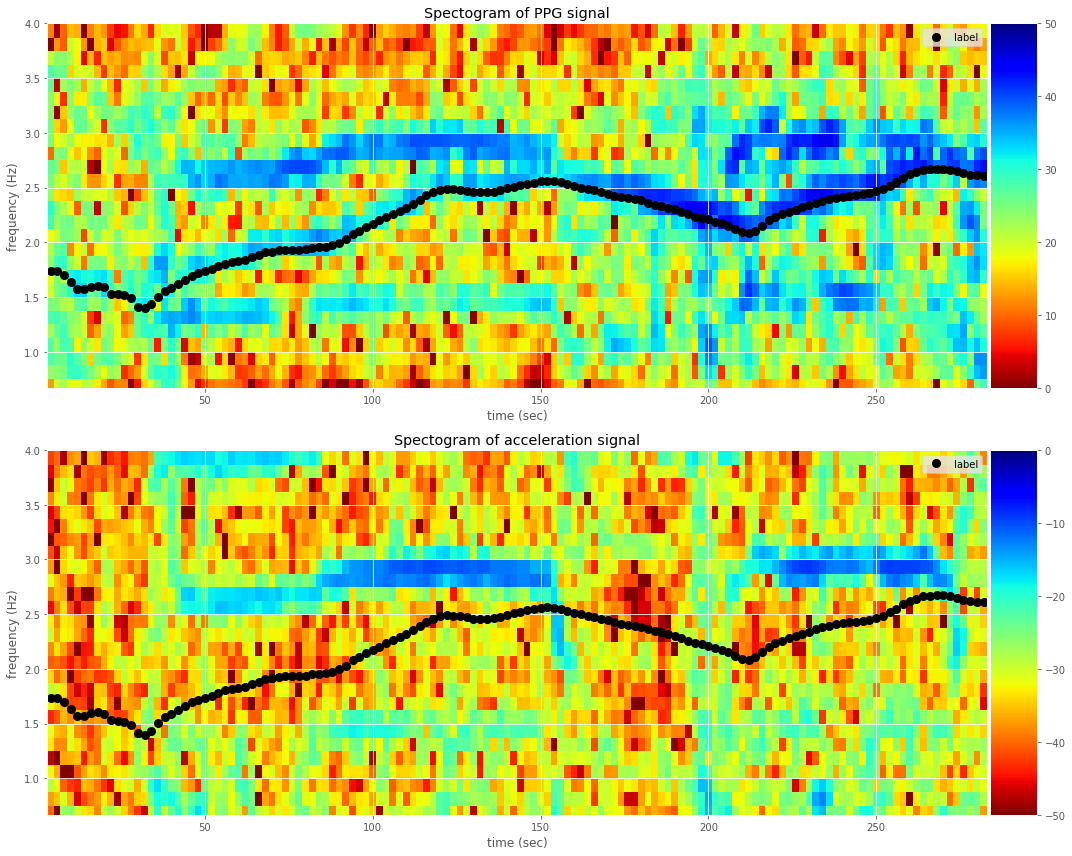

In [32]:
file = 'data_03_type02'
ppg_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['ppg'], pass_band=(min_freq, max_freq), fs=FS)
accx_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accx'], pass_band=(min_freq, max_freq), fs=FS)
accy_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accy'], pass_band=(min_freq, max_freq), fs=FS)
accz_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accz'], pass_band=(min_freq, max_freq), fs=FS)
acc_abs, _ = etl.total_accelerometer_signal(accx=accx_raw_filtered, accy=accy_raw_filtered, accz=accz_raw_filtered, n_fft=n_fft)
fig = plot_util.plot_spectogram_sumarized(
    ppg=ppg_raw_filtered,
    acc=acc_abs,
    labels=labels_raw[f'ref{file[4:]}']/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

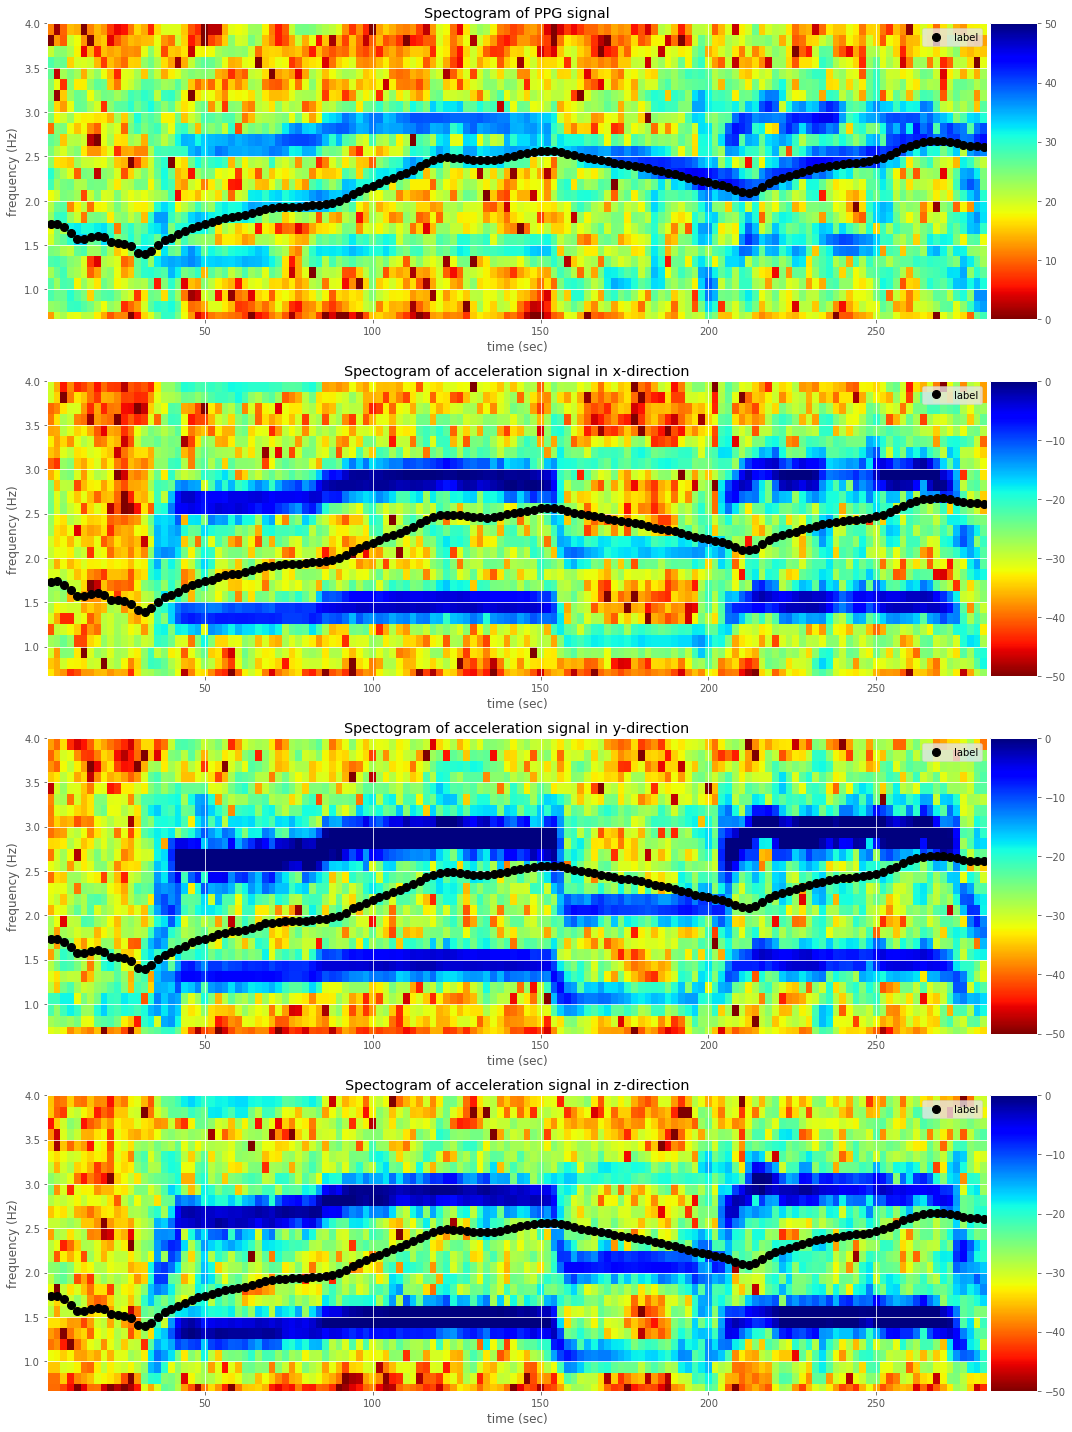

In [33]:
file = 'data_03_type02'
ppg_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['ppg'], pass_band=(min_freq, max_freq), fs=FS)
accx_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accx'], pass_band=(min_freq, max_freq), fs=FS)
accy_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accy'], pass_band=(min_freq, max_freq), fs=FS)
accz_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accz'], pass_band=(min_freq, max_freq), fs=FS)
fig = plot_util.plot_spectogram(
    ppg=ppg_raw_filtered,
    accx=accx_raw_filtered,
    accy=accy_raw_filtered,
    accz=accz_raw_filtered,
    labels=labels_raw[f'ref{file[4:]}']/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

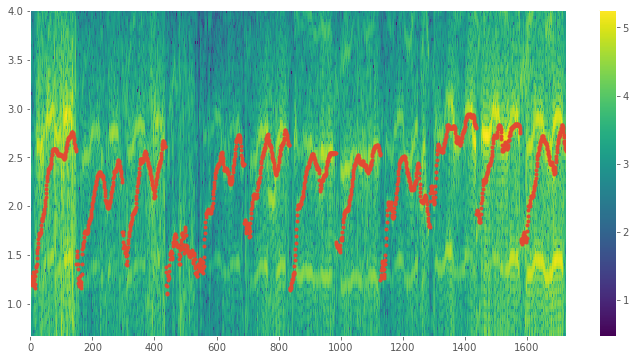

In [13]:
msk = (dict_data_raw_window['freqs']>=min_freq) & (dict_data_raw_window['freqs']<=max_freq)
a = dict_data_raw_window['fft_ppg']*msk
plt.pcolormesh(np.arange(len(labels)), dict_data_raw_window['freqs'][:, 22:129][0], np.log10(a[:, 22:129]).transpose(), shading='nearest')
plt.plot(np.arange(len(labels)), labels/60, '.')
plt.colorbar()

In [14]:
# def RunPulseRateAlgorithm(data_fl, ref_fl):
#     # Sample Frequency
#     fs = 125
#     # Window to calculate reference pulse rate
#     win_len = 8
#     # Difference between time windows
#     win_shift = 2    
       
#     reg, scores = load_regressor()
#     targets, features, sigs, subs = load_data(data_fl, ref_fl)
#     error, confidence = [], []
#     for i,feature in enumerate(features):
#         est = reg.predict(np.reshape(feature, (1, -1)))[0]
        
#         # Calculate confidence
#         ppg, accx, accy, accz = sigs[i]
        
#         ppg = bandpass_filter(ppg)        
#         accx = bandpass_filter(accx)
#         accy = bandpass_filter(accy)
#         accz = bandpass_filter(accz)        
        
#         n = len(ppg) * 3
#         freqs = np.fft.rfftfreq(n, 1/fs)
#         fft = np.abs(np.fft.rfft(ppg,n))
#         fft[freqs <= 40/60.0] = 0.0
#         fft[freqs >= 240/60.0] = 0.0
    
#         # Max magnitude frequency
#         est_fs = est / 55.0
#         fs_win = 30  / 60.0
#         fs_win_e = (freqs >= est_fs - fs_win) & (freqs <= est_fs +fs_win)
#         conf = np.sum(fft[fs_win_e])/np.sum(fft)
        
#         error.append(np.abs((est-targets[i])))
#         confidence.append(conf)
#     return np.array(error), np.array(confidence)

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 

group: data_02_type02
label: 137.6889848812095 BPM (2.2948164146868253 Hz)


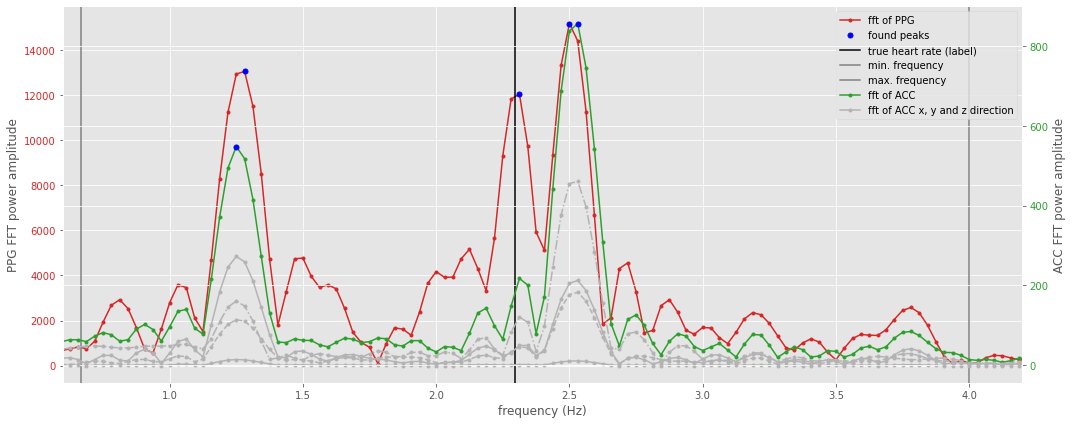

In [401]:
peaks_param = {
    'ppg': {
        'nr_peaks': 3,
        'height': 0.1,
        'distance': 5,
        'prominence': 0.2,
        'wlen': 200,
        'pad_value': -1,
    },
#     'acc_abs': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': 0.2,
#         'wlen': 100,
#         'pad_value': -1,
#     },
    'acc_sum': {
        'nr_peaks': 3,
        'height': 0.2,
        'distance': 10,
        'prominence': 0.2,
        'wlen': 100,
        'pad_value': -1,
    },
}

# get all features:
dict_features = etl.featurize(
    dict_raw_window_data=dict_data_raw_window,
    peaks_param=peaks_param,
    frac_en_param=frac_en_param,
    freq_range=(min_freq, max_freq)
)
features, feature_names = etl.transform_features(dict_features=dict_features)


# plot a window data point
i = 234
abr = 'sum'
fig = plot_util.plot_window_prediction(
    freqs=dict_data_raw_window['freqs'][i],
    ppg_fft=dict_data_raw_window['fft_ppg'][i],
    ppg_peaks_freqs=dict_features['peaks_freq_ppg'][i],
    ppg_peaks_pwr=dict_features['peaks_pwr_ppg'][i],
    ppg_label=labels[i],
    acc_fft=dict_data_raw_window[f'fft_acc_{abr}'][i],
    accx_fft=dict_data_raw_window['fft_accx'][i],
    accy_fft=dict_data_raw_window['fft_accy'][i],
    accz_fft=dict_data_raw_window['fft_accz'][i],
    acc_peaks_freqs=dict_features[f'peaks_freq_acc_{abr}'][i],
    acc_peaks_pwr=dict_features[f'peaks_pwr_acc_{abr}'][i],
    min_freq=min_freq,
    max_freq=max_freq
)
print(f'group: {groups[i]}')
print(f'label: {labels[i]} BPM ({labels[i]/60} Hz)')

# plot a window data point
# abr = 'abs'
# fig = plot_util.plot_window_prediction(
#     freqs=dict_data_raw_window['freqs'][i],
#     ppg_fft=dict_data_raw_window['fft_ppg'][i],
#     ppg_peaks_freqs=dict_features['peaks_freq_ppg'][i],
#     ppg_peaks_pwr=dict_features['peaks_pwr_ppg'][i],
#     ppg_label=labels[i],
#     acc_fft=dict_data_raw_window[f'fft_acc_{abr}'][i],
#     accx_fft=dict_data_raw_window['fft_accx'][i],
#     accy_fft=dict_data_raw_window['fft_accy'][i],
#     accz_fft=dict_data_raw_window['fft_accz'][i],
#     acc_peaks_freqs=dict_features[f'peaks_freq_acc_{abr}'][i],
#     acc_peaks_pwr=dict_features[f'peaks_pwr_acc_{abr}'][i],
#     min_freq=min_freq,
#     max_freq=max_freq
# )
# print(f'group: {groups[i]}')
# print(f'label: {labels[i]} BPM ({labels[i]/60} Hz)')